In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from mpl_toolkits.basemap import Basemap, cm
import pyowm
import time
import math
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel, RBF, RationalQuadratic, ConstantKernel as C

#Define a distance
def sq_distance(lon1, lat1, lon2, lat2):
    d = (lon2-lon1)**2 + (lat2-lat1)**2
    return d
    
def hv_distance(lon1, lat1, lon2, lat2):
    radius = 6371 # km
    dlat = math.radians(lat2-lat1)
    dlon = math.radians(lon2-lon1)
    a = math.sin(dlat/2) * math.sin(dlat/2) + math.cos(math.radians(lat1)) \
        * math.cos(math.radians(lat2)) * math.sin(dlon/2) * math.sin(dlon/2)
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))
    d = radius * c
    return d
    
    
#Nearest neighbor with plane euclidian distance
def NNI_temp(xlon, xlat, ylon, ylat, temp, prediction):
    nx = prediction.shape[0]
    ny = prediction.shape[1]
    for i_x in range(0, nx):
        if i_x % 10 == 0:
            print('i_x = %d' % i_x)
        for i_y in range(0, ny):
            distance_to_closest = 0
            idx_closest = -1
            distance = 0
            for it in range(0, len(xlon)):
                #distance = sq_distance(ylon[i_x][i_y], ylat[i_x][i_y], xlon[it], xlat[it])
                distance = hv_distance(ylon[i_x][i_y], ylat[i_x][i_y], xlon[it], xlat[it])
                if (idx_closest < 0):
                    distance_to_closest = distance
                    idx_closest = it
                elif (distance_to_closest > distance):
                    distance_to_closest = distance
                    idx_closest = it
            prediction[i_x][i_y] = temp[idx_closest]
            
            
#Inverse distance weighting
#Param: radius of the IDW, if no points in the radius -> NNI 
def IDW_temp(xlon, xlat, ylon, ylat, temp, prediction, radius):
    nx = prediction.shape[0]
    ny = prediction.shape[1]
    for i_x in range(0, nx):
        if i_x % 10 == 0:
            print('i_x = %d' % i_x)
        for i_y in range(0, ny):
            numerator = 0
            denominator = 0
            idx_closest = -1
            distance = 0
            distance_to_closest = 0
            for it in range(0, len(xlon)):
                #distance = math.sqrt(sq_distance(ylon[i_x][i_y], ylat[i_x][i_y], xlon[it], xlat[it]))
                distance = hv_distance(ylon[i_x][i_y], ylat[i_x][i_y], xlon[it], xlat[it])
                if (idx_closest < 0):
                    distance_to_closest = distance
                    idx_closest = it
                elif (distance_to_closest > distance):
                    distance_to_closest = distance
                    idx_closest = it
                if (distance < radius):
                    numerator += temp[it]/distance
                    denominator += 1/distance
            if (denominator == 0):
                prediction[i_x][i_y] = temp[idx_closest]
            else:
                prediction[i_x][i_y] = numerator/denominator
        
def GaussProcess_temp(xlon, xlat, ylon, ylat, temp, prediction):
    
    X = np.asarray([[0.0]*2 for i in range(len(xlat))])
    k=0
    for i, j in zip(xlat, xlon):
        X[k][0]=i
        X[k][1]=j
        k+=1
    
    y = np.asarray([0.0 for i in range(len(temp))])
    k=0
    for t in temp:
        y[k] = t
        k+=1
        
    grid = np.asarray([[0.0]*2 for i in range(len(glats)*len(glons))])
    k=0
    k1=0
    k2=0
    for rlat in glats:
        k2=0
        for rlon in glons:
            grid[k][0] = rlat[k1]
            grid[k][1] = rlon[k2]
            k2+=1
            k+=1
        k1+=1
    
    kernel = C(1.0)*RBF(length_scale=[10.0, 10.0]) + WhiteKernel(0.1)
    #gpr = GaussianProcessRegressor(kernel=kernel, alpha = 0, optimizer='fmin_l_bfgs_b', n_restarts_optimizer=10, normalize_y=True, random_state=0).fit(X, y)
    gpr = GaussianProcessRegressor(kernel=kernel, alpha = 0, optimizer=None, n_restarts_optimizer=10, normalize_y=True, random_state=0).fit(X, y)
    print("score: %f" % gpr.score(X, y))
    preds = gpr.predict(grid)
    print(gpr.kernel_)
 
    k1=0
    k2=0
    for i in range(nx):
        mat_row=[]
        for j in range(ny):
            mat_row.append(preds[k1])
            k1+=1
        prediction[k2] = mat_row
        k2+=1
    
    
def null_kernel(X, y):
    return 0


In [12]:
#Read cities list
obs = pd.read_csv("data/current-version/Temp-2018_12_23-12_0.csv", ',')
obs = obs.drop(['Unnamed: 0'], axis=1)

In [13]:
#Get cities coordinates and ID
nam = obs['City'].tolist()
lon = obs['Lon'].tolist()
lat = obs['Lat'].tolist()
ids = obs['ID'].tolist()
temps = obs['Temp'].tolist()

score: 0.472718
1**2 * RBF(length_scale=[10, 10]) + WhiteKernel(noise_level=0.1)


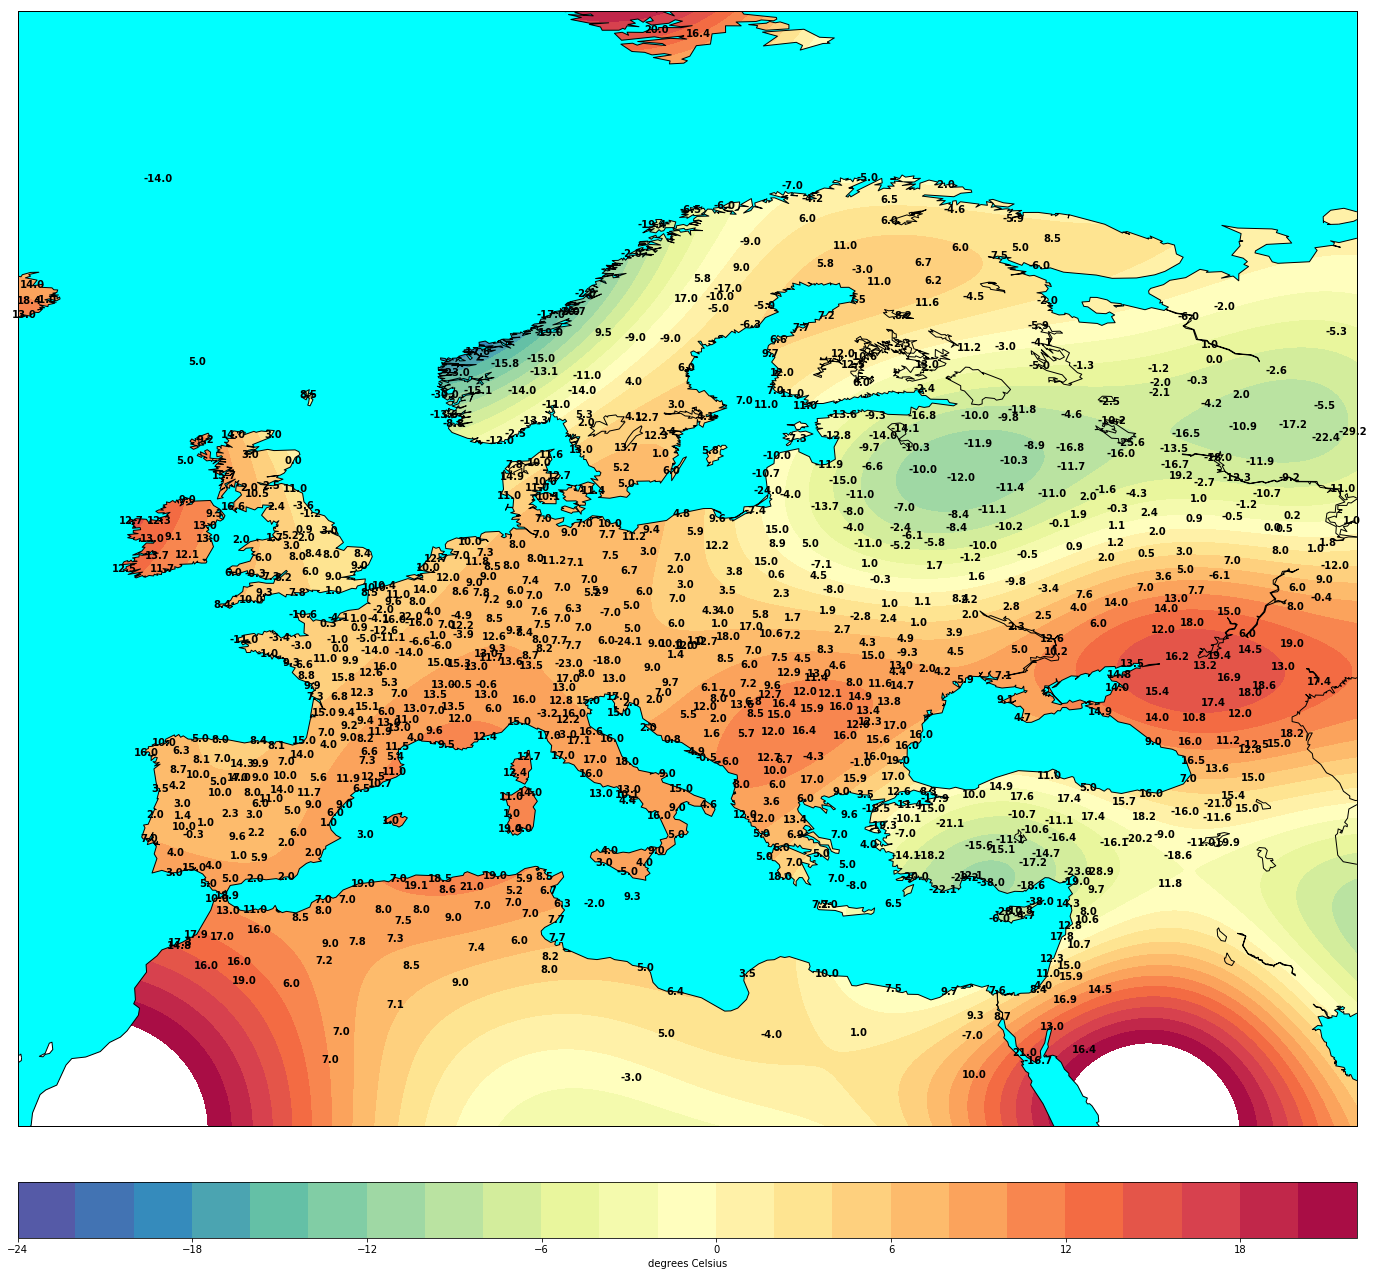

In [14]:
#Map boundaries
lon_min = -15.56
lat_min = 24.65
lon_max = 49.88
lat_max = 79.17

#Interpolation resolution
nx = 400
ny = 400

cities_out_bounds = []

#Create map
fig, ax = plt.subplots(figsize=(24,24))
map = Basemap(llcrnrlon=lon_min,llcrnrlat=lat_min,urcrnrlon=lon_max,urcrnrlat=lat_max, resolution = 'l', epsg=4668)
map.drawmapboundary(fill_color='white')
#map.fillcontinents(color='coral',lake_color='white')
map.drawcoastlines()

x, y = map(lon, lat)

#Create annotations for temperature and only keep cities in bound
for i in range(0,len(x)-1):
    if lon[i] > lon_min and lon[i] < lon_max and lat[i] > lat_min and lat[i] < lat_max:
        plt.text(x[i], y[i], "{0:.1f}".format(temps[i]),fontsize=10,fontweight='bold', ha='center',va='center',color='k')
    else:
        cities_out_bounds.append(nam[i])

glons, glats = map.makegrid(nx, ny)
gx, gy = map(glons, glats)
predict = np.zeros((nx, ny))

#Interpolation
#NNI_temp(lon, lat, glons, glats, temps, predict)
#IDW_temp(lon, lat, glons, glats, temps, predict, 500)
GaussProcess_temp(lon, lat, glons, glats, temps, predict)

#Plot contours
clevs = [-24,-22,-20,-18,-16,-14,-12,-10,-8,-6,-4,-2,0,2,4,6,8,10,12,14,16,18,20,22]
cs = map.contourf(gx,gy,predict,clevs,cmap='Spectral_r')

#Display colorbar
cbar = map.colorbar(cs,location='bottom',pad="5%")
cbar.set_label('degrees Celsius')


from matplotlib.patches import Path, PathPatch

##getting the limits of the map:
x0,x1 = ax.get_xlim()
y0,y1 = ax.get_ylim()
map_edges = np.array([[x0,y0],[x1,y0],[x1,y1],[x0,y1]])

##getting all polygons used to draw the coastlines of the map
polys = [p.boundary for p in map.landpolygons]

##combining with map edges
polys = [map_edges]+polys[:]

##creating a PathPatch
codes = [
    [Path.MOVETO] + [Path.LINETO for p in p[1:]]
    for p in polys
]
polys_lin = [v for p in polys for v in p]
codes_lin = [c for cs in codes for c in cs]
path = Path(polys_lin, codes_lin)
patch = PathPatch(path,facecolor='cyan', lw=0)

##masking the data:
ax.add_patch(patch)
